<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/SW_DenseNet121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [2]:
!nvidia-smi

Thu May 21 16:40:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 51.78 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [8]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['dx'])
name_as_indexes_train = encoder.transform(train['dx']) 
train['label'] = name_as_indexes_train

In [12]:
print(name_as_indexes_train.shape)
print(name_as_indexes_train)

(6309,)
[3 5 5 ... 2 5 5]


In [0]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_val = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_val

In [14]:
print(name_as_indexes_val.shape)
print(name_as_indexes_val)

(2704,)
[5 5 2 ... 2 5 5]


In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

In [16]:
print(name_as_indexes_test.shape)
print(name_as_indexes_test)

(1002,)
[4 5 4 ... 6 1 5]


### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [18]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Class Weights**

In [0]:
class_weights = class_weight.compute_sample_weight('balanced', name_as_indexes_train)

In [20]:
print(class_weights)

[11.40867993  0.21181803  0.21181803 ...  1.32542017  0.21181803
  0.21181803]


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use DenseNet121 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
29089792/29084464 [==============================] - 1s 0us/step


### **Architecture**

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [30]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            class_weight=class_weights,
                            epochs=EPOCHS,
                            callbacks=cb_list)

Epoch 1/100
 84/197 [===========>..................] - ETA: 37s - loss: 1.7084 - acc: 0.5539
Epoch 00001: val_loss improved from -inf to 1.70840, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 255s 1s/step - loss: 2.1199 - acc: 0.2737 - val_loss: 1.7084 - val_acc: 0.5539
Epoch 2/100
 84/197 [===========>..................] - ETA: 34s - loss: 1.3092 - acc: 0.6510
Epoch 00002: val_loss did not improve from 1.70840
197/197 [==============================] - 144s 732ms/step - loss: 1.8157 - acc: 0.4540 - val_loss: 1.3092 - val_acc: 0.6510
Epoch 3/100
 84/197 [===========>..................] - ETA: 35s - loss: 1.2812 - acc: 0.6812
Epoch 00003: val_loss did not improve from 1.70840
197/197 [==============================] - 143s 726ms/step - loss: 1.6396 - acc: 0.5573 - val_loss: 1.2812 - val_acc: 0.6812
Epoch 4/100
 84/197 [===========>..................] - ETA: 34s - loss: 1.2791 - acc: 0.6890
Epoch 00004: val_loss did not improve from 1.70

In [0]:
model.save_weights('/content/Focal-Loss_ResNet50_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

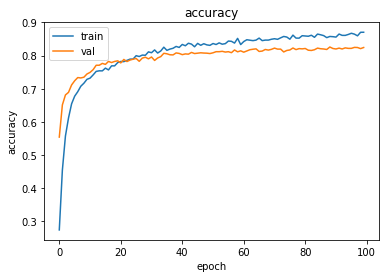

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

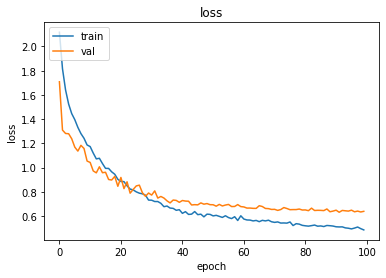

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [34]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 27s 27ms/step


### **Classification Report**

In [35]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[  9   3  13   1  10   5   0]
 [  2  33   3   0   4   5   0]
 [  1   3  90   0   8  23   0]
 [  1   2   2   4   0   6   0]
 [  1   1  18   1  61  28   0]
 [  0   2  25   0  16 605   1]
 [  0   0   0   0   0   0  15]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.64      0.22      0.33        41
         bcc       0.75      0.70      0.73        47
         bkl       0.60      0.72      0.65       125
          df       0.67      0.27      0.38        15
         mel       0.62      0.55      0.58       110
          nv       0.90      0.93      0.92       649
        vasc       0.94      1.00      0.97        15

    accuracy                           0.82      1002
   macro avg       0.73      0.63      0.65      1002
weighted avg       0.81      0.82      0.81      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  9   3  13   1  10   5   0]
 [  2  33   3   0   4   5   0]
 [  1   3  90   0   8  23   0]
 [  1   2   2   4   0   6   0]
 [  1   1  18   1  61  28   0]
 [  0   2  25   0  16 605   1]
 [  0   0   0   0   0   0  15]]


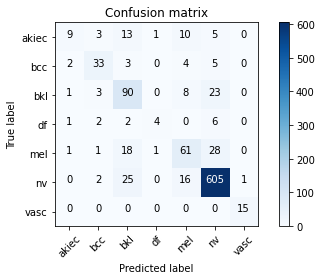

In [36]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [38]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.7500
specificity: 0.9429


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block16_2_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.980
	bkl            	(2)	with probability 0.011
	akiec          	(0)	with probability 0.006
	df             	(3)	with probability 0.001
	bcc            	(1)	with probability 0.001
Explanation for 'mel'


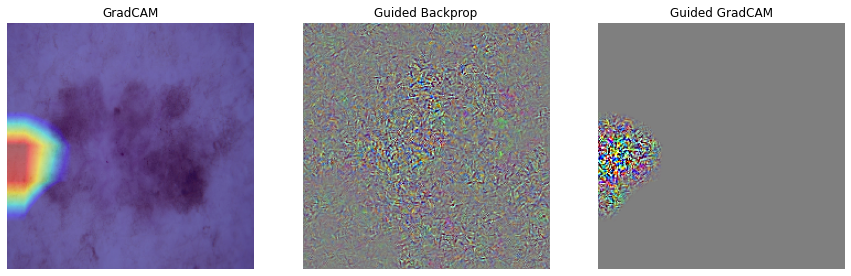

In [41]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.873
	bcc            	(1)	with probability 0.039
	mel            	(4)	with probability 0.038
	akiec          	(0)	with probability 0.018
	bkl            	(2)	with probability 0.012
Explanation for 'nv'


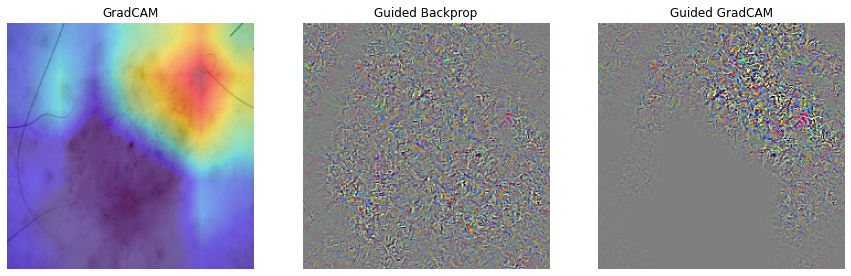

In [43]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.841
	bkl            	(2)	with probability 0.140
	akiec          	(0)	with probability 0.006
	vasc           	(6)	with probability 0.005
	df             	(3)	with probability 0.005
Explanation for 'mel'


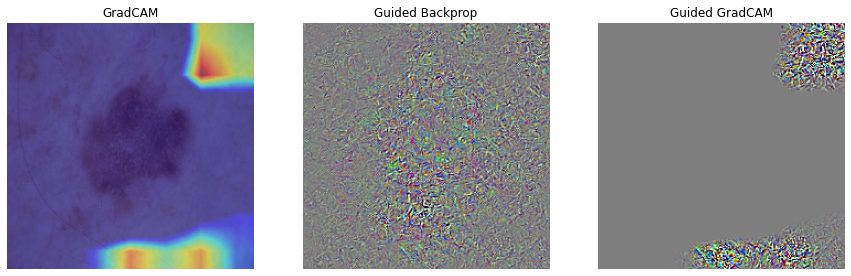

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.445
	bkl            	(2)	with probability 0.237
	nv             	(5)	with probability 0.180
	df             	(3)	with probability 0.095
	vasc           	(6)	with probability 0.028
Explanation for 'mel'


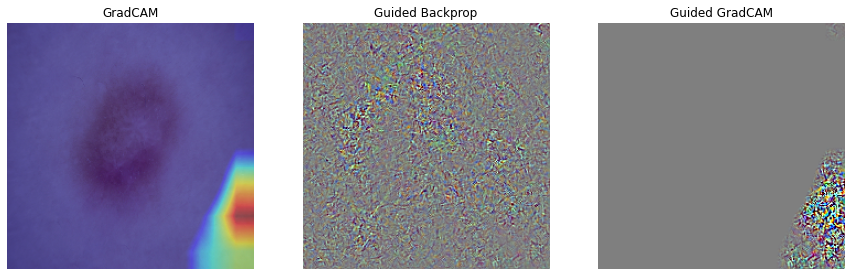

In [47]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.942
	nv             	(5)	with probability 0.028
	bkl            	(2)	with probability 0.017
	akiec          	(0)	with probability 0.007
	bcc            	(1)	with probability 0.003
Explanation for 'mel'


/content/ham10000_utils_functions.py:136: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


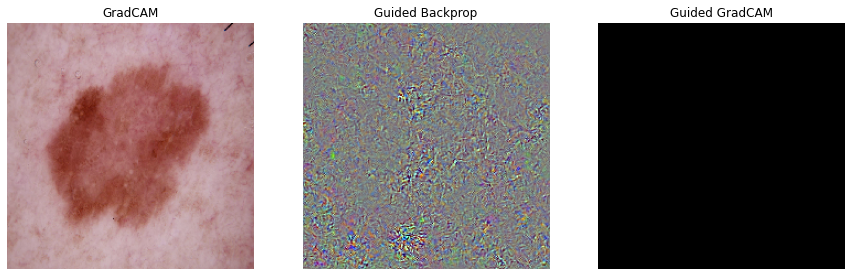

In [49]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.619
	mel            	(4)	with probability 0.254
	vasc           	(6)	with probability 0.068
	bkl            	(2)	with probability 0.032
	df             	(3)	with probability 0.014
Explanation for 'nv'


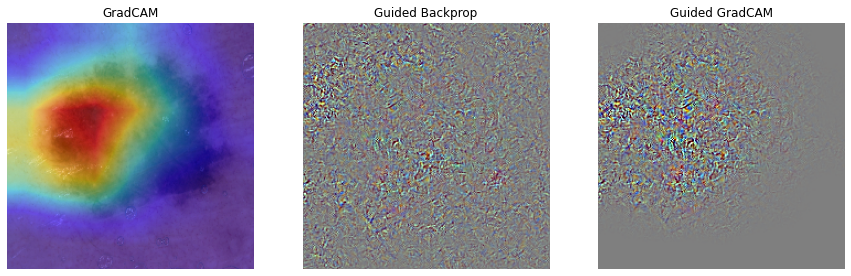

In [51]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.995
	bkl            	(2)	with probability 0.002
	mel            	(4)	with probability 0.001
	akiec          	(0)	with probability 0.001
	df             	(3)	with probability 0.001
Explanation for 'vasc'


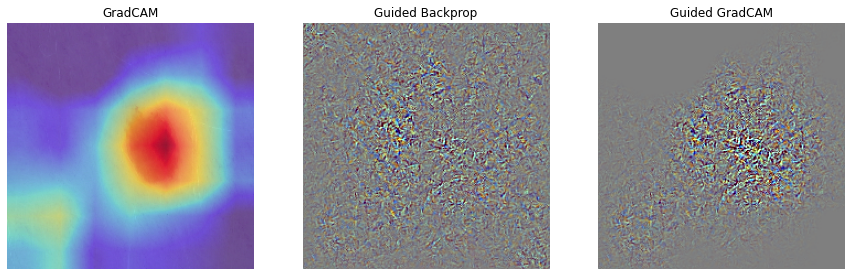

In [53]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [55]:
files.download('/content/CW_Focal-Loss_ResNet50_model.h5')
files.download('/content/CW_Focal-Loss_ResNet50_weights.h5')

FileNotFoundError: ignored